# BigGAN exercise solutions
* Easy: Create images that blend two image classes. You can simply set multiple elements to a non-zero value in the y vectors.
* Slightly harder: Once you manage to create a good image, generate small variations of it
* Slightly harder: Interpolate between two images from different two classes. This can be done by interpolating between pairs of z and y vectors. If you've never done this, see here: https://gamedev.stackexchange.com/questions/18615/how-do-i-linearly-interpolate-between-two-vectors
* Advanced: load some target image, e.g., your own face. Define the module inputs as Tensorflow variables and optimize the variables to maximize the similarity between the generator output and the target image. This is somewhat similar to the [adversarial MNIST tutorial](AdversarialMNIST.ipynb). In other words, find the latent space coordinates that make the generator generate an image of you. Once you know the coordinates, you can try interpolating between you and some other images. (No model solution provided for this yet!). 

Let's first get the network ready for sampling (this is the same code as in the exercise notebook)

In [1]:
#the pylab inline may be needed to make figures visible in Jupyter, depending on your Anaconda installation
%pylab inline
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # comment this out if your tensorflow works ok with GPU
import tensorflow as tf
import tensorflow_hub as hub

# Define the BigGAN model. The "128" means a 128x128 pixel model which is reasonably fast
# to run without a beefy GPU. There are also 256x256 and 512x512 models available
# Uncomment the one you want to test.
print("Loading BigGAN module")
module = hub.Module('https://tfhub.dev/deepmind/biggan-deep-128/1')
print("Module input info:")
print(module.get_input_info_dict())
print("Module output info:")
print(module.get_output_info_dict())

print("Creating the sampling ops")
# The generator needs two inputs: random noise (z) and ImageNet class label (y).
# We define placeholders for these, which will make it easy to do experiments after 
# everything has been initialized
yIn=tf.placeholder(dtype=tf.float32,shape=[None,1000])  #there are 1000 classes
zIn=tf.placeholder(dtype=tf.float32,shape=[None,128]) #these deep BigGAN models have as many latent dimensions as pixel width and height
truncationIn=tf.placeholder(dtype=tf.float32)#this is just a sincle floating point number

# This tensor will hold the samples
samples = module(dict(y=yIn, z=zIn, truncation=truncationIn))

# As always, we need to have a Tensorflow session and initialize the variables.
print("Creating the session")
sess=tf.Session()
print("Initializing variables")
tf.global_variables_initializer().run(session=sess)
print("Done! You should now be able to generate samples.")

c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.BNVRK7633HSX7YVO2TADGR4A5KEKXJAW.gfortran-win_amd64.dll
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


Populating the interactive namespace from numpy and matplotlib


W0417 13:37:33.134781 18164 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Loading BigGAN module
Instructions for updating:
Colocations handled automatically by placer.


W0417 13:37:48.575908 18164 deprecation.py:323] From c:\CondaEnvs\tensorflow2\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Module input info:
{'z': <hub.ParsedTensorInfo shape=(?, 128) dtype=float32 is_sparse=False>, 'y': <hub.ParsedTensorInfo shape=(?, 1000) dtype=float32 is_sparse=False>, 'truncation': <hub.ParsedTensorInfo shape=() dtype=float32 is_sparse=False>}
Module output info:
{'default': <hub.ParsedTensorInfo shape=(?, 128, 128, 3) dtype=float32 is_sparse=False>}
Creating the sampling ops
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0417 13:38:09.503886 18164 saver.py:1483] Saver not created because there are no variables in the graph to restore


Creating the session
Initializing variables
Done! You should now be able to generate samples.


# Exercise 1: create images that blend or crossbreed two classes

This is easy: we just set the probability of multiple classes to some nonzero value. First try setting both to 1, but if one class seems to dominate, you can slightly decrease its probability

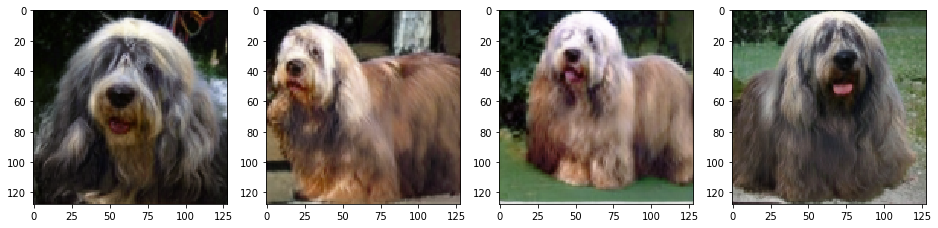

In [14]:
# We want this many images at a time
batch_size = 4

#these deep BigGAN models have as many latent dimensions as pixel width and height
N=128 

# Define how much variety we get.
truncation = 0.5    

#The model is conditioned by the 1000-value discrete probability distribution of classes.
#First, we initialize the distribution to zeroes
y=np.zeros([batch_size,1000])
# 220 and 229 are both breeds of dog, let's crossbreed
y[:,220]=1 
y[:,229]=1 

# The latent space vector, randomized
z = truncation*np.random.normal(size=[batch_size, N])  # random vector

#Run the network, feeding the values computed above to the placeholder input tensors
samples_fetched=sess.run(samples,feed_dict={zIn:z,yIn:y,truncationIn:truncation})

#Plot
pp.figure(1,figsize=[batch_size*4,4])
for i in range(batch_size):
    pp.subplot(1,batch_size,1+i)
    pp.imshow(samples_fetched[i]*0.5+0.5)

# Exercise 2: Create small variations

This can be done by keeping the z of some image and then adding some noise to it

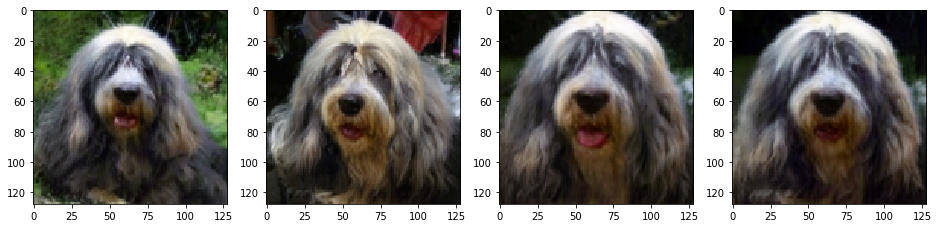

In [17]:
#Let's suppose we want variations of the first image of the batch above
template=z[0,:]

#Now, we create new z by using adding some noise. You can experiment with the noise multiplier.
variations=template+0.2*np.random.normal(size=[batch_size, N])

#Run the network, feeding the values computed above to the placeholder input tensors
samples_fetched=sess.run(samples,feed_dict={zIn:variations,yIn:y,truncationIn:truncation})

#Plot
pp.figure(1,figsize=[batch_size*4,4])
for i in range(batch_size):
    pp.subplot(1,batch_size,1+i)
    pp.imshow(samples_fetched[i]*0.5+0.5)

# Exercise 3: Interpolate between two images

Here, we need to interpolate between two pairs of z and y. The easiest way to do this is linear interpolation, i.e., "cross-fading" between the vectors

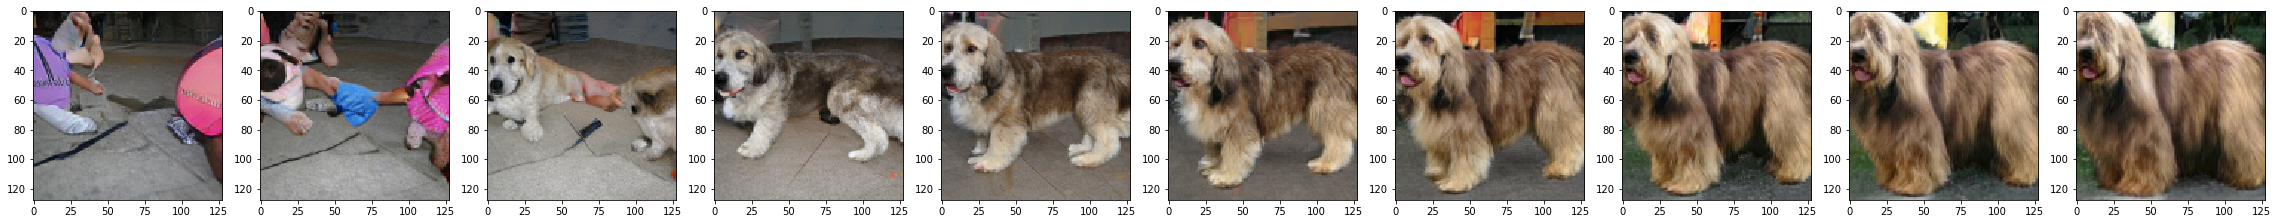

In [23]:
#this many interpolation steps
batch_size=10

#Let's just randomly pick the z vectors
z1=truncation*np.random.normal(size=N)  
z2=truncation*np.random.normal(size=N)

#We will use one-hot y vectors
y1=np.zeros(1000)
y1[229]=1
y2=np.zeros(1000)
y1[220]=1

#Reserve space for the interpolated
z=np.zeros([batch_size,128])
y=np.zeros([batch_size,1000]) 

#Interpolate: The np.linspace() below returns a vector of batch_size elements, values sweeping from 0 to 1
#You could also compute the mixing factor for z1,y1 inside the for loop as (i+1)/batchSize
t=np.linspace(0,1,batch_size)
for i in range(batch_size):
    #we mix together z1 and z2 weighted by t[i] and (1-t[i]), i.e., the mixing weights sum to 1
    z[i]=t[i]*z1+(1.0-t[i])*z2
    y[i]=t[i]*y1+(1.0-t[i])*y2
  
#Run the network, feeding the values computed above to the placeholder input tensors
samples_fetched=sess.run(samples,feed_dict={zIn:z,yIn:y,truncationIn:truncation})

#Plot
pp.figure(1,figsize=[batch_size*4,4])
for i in range(batch_size):
    pp.subplot(1,batch_size,1+i)
    pp.imshow(samples_fetched[i]*0.5+0.5)
